In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np

import requests
import random
import xlrd
import csv
from datetime import datetime
import os
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
import matplotlib as mpl
import matplotlib.style
import seaborn as sns  
import matplotlib.pyplot as plt
# setting to default parameters
plt.rcParams.update(plt.rcParamsDefault)

# formatting for decimal places
pd.set_option("display.float_format", "{:.2f}".format)

sns.set_style("white")
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

# matplotlib settings
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('seaborn-white')
mpl.rcParams["figure.figsize"] = (12, 8)
mpl.rcParams["axes.grid"] = False

In [2]:
# setting seed for model reproducibility
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

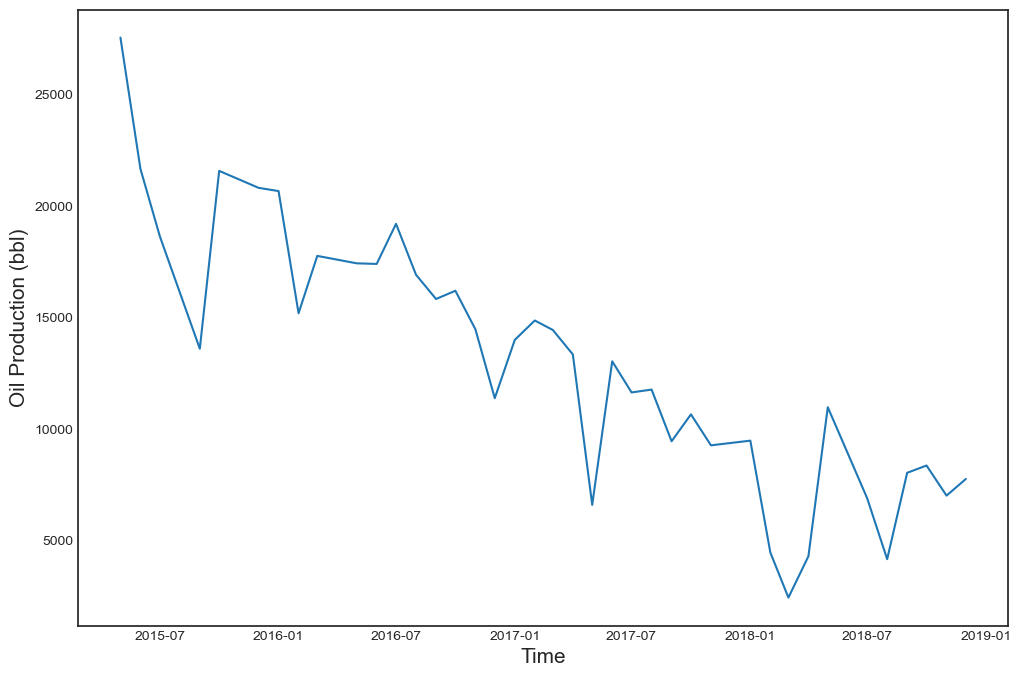

In [3]:
train_prod = pd.read_csv('data/train_prod.csv')
test_prod = pd.read_csv("data/test_prod.csv")
train_prod = train_prod[train_prod["API_WELLNO"] ==  33055001360000]
train_prod.drop("Unnamed: 0", axis=1, inplace=True)
train_prod.dropna(inplace=True)
# drop rows where data is 0
train_prod = train_prod[(train_prod['Oil'].notnull()) & (train_prod['Oil'] > 0)]
train_prod["ReportDate"] = pd.to_datetime(train_prod["ReportDate"])
train_prod.set_index("ReportDate", inplace=True)
train_prod.nunique()


timeseries_train= train_prod["Oil"]
timeseries_train.head()
plt.plot(timeseries_train)
plt.xlabel('Time', fontsize = 15)
plt.ylabel('Oil Production (bbl)', fontsize = 15)
plt.show()

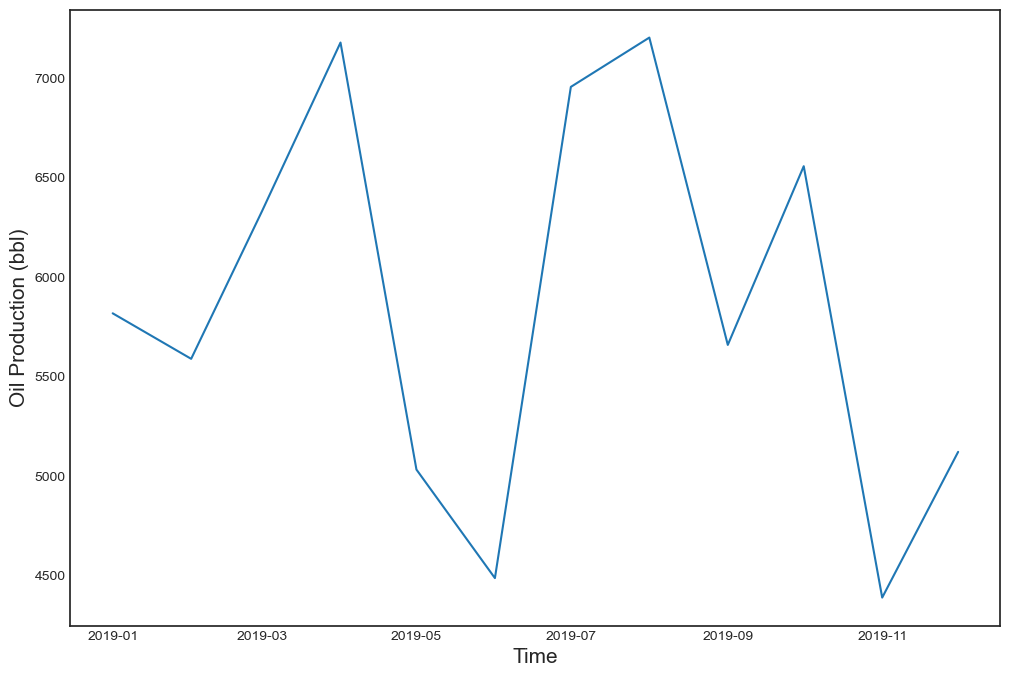

In [4]:
test_prod = test_prod[test_prod["API_WELLNO"] == 33055001360000]
test_prod.drop("Unnamed: 0", axis=1, inplace=True)
test_prod.dropna(inplace=True)
# drop rows where data is 0
test_prod = test_prod[(test_prod['Oil'].notnull()) & (test_prod['Oil'] > 0)]
test_prod["ReportDate"] = pd.to_datetime(test_prod["ReportDate"])
test_prod.set_index("ReportDate", inplace=True)
test_prod.nunique()


timeseries_test = test_prod["Oil"]
timeseries_test.head()
plt.plot(timeseries_test)
plt.xlabel('Time', fontsize = 15)
plt.ylabel('Oil Production (bbl)', fontsize = 15)
plt.show()

In [5]:
# ADF - Augmented Dickey-Fuller unit root test - to test stationarity
print("p-value:", adfuller(timeseries_train.dropna())[1])

p-value: 0.7885312328902487


In [6]:
# Perform Dickey-Fuller test:
def dickey_ful_test(series):
    print("Results of Dickey-Fuller Test:")
    df_test = adfuller(series, autolag="AIC")
    df_output = pd.Series(df_test[0:4],index=["Test Statistic","p-value","#Lags Used","Number of Observations Used"])
    for key, value in df_test[4].items():
        df_output["Critical Value (%s)" % key] = value
    print(df_output)

def stationary_test_plot(metric, data_series, method):
    plt.figure(figsize=(10, 6))
    orig = plt.plot(data_series, label="Original")
    metric = plt.plot(metric, label= method)
    plt.legend(loc="best")
    #plt.title(method)
    plt.xlabel('Time',fontsize = 15)
    plt.ylabel('Oil Production (bbls)',fontsize = 15)
    plt.show()

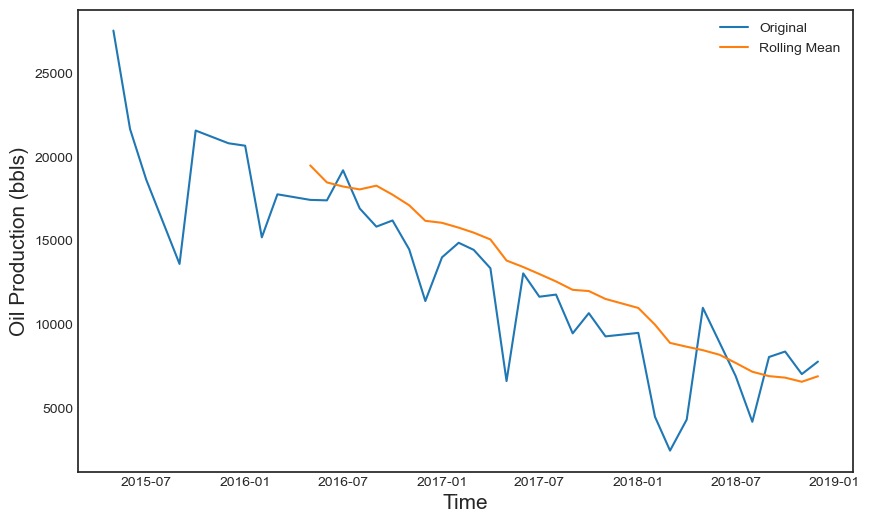

Results of Dickey-Fuller Test:
Test Statistic                -0.90
p-value                        0.79
#Lags Used                     3.00
Number of Observations Used   36.00
Critical Value (1%)           -3.63
Critical Value (5%)           -2.95
Critical Value (10%)          -2.61
dtype: float64


In [7]:
def stationary_test(data_series, method):
    rolling_mean = data_series.rolling(10).mean()
    stationary_test_plot(rolling_mean, data_series, method)
    dickey_ful_test(data_series)

# test if the time series data is stationary or not
stationary_test(timeseries_train, "Rolling Mean")

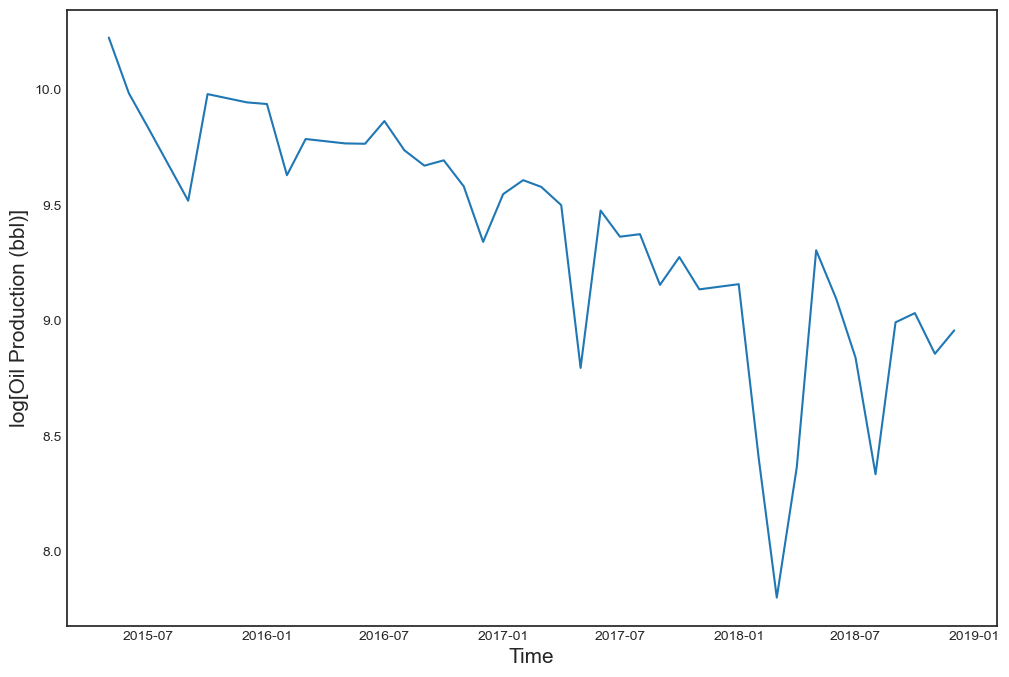

In [8]:
ts_log = np.log(timeseries_train)
plt.plot(ts_log)
plt.xlabel('Time', fontsize = 15)
plt.ylabel('log[Oil Production (bbl)]', fontsize = 15)
plt.show()
plt.show()

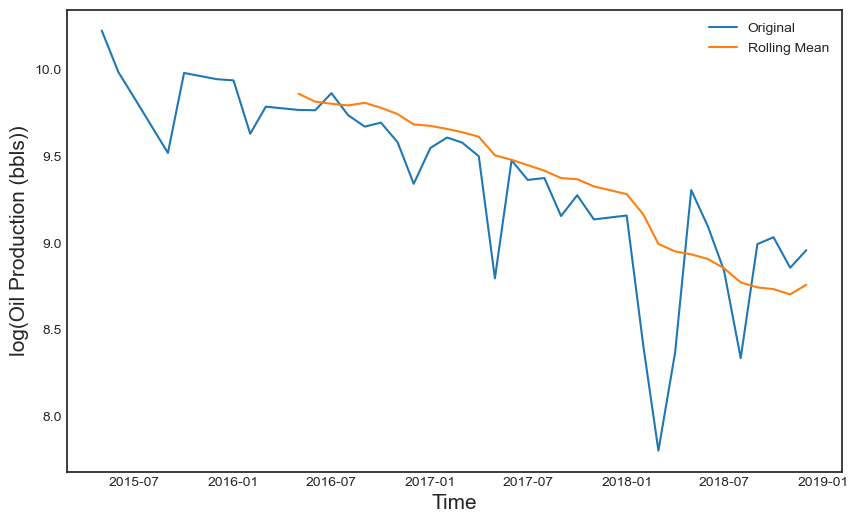

In [9]:
# rolling mean estimation and plot
rolling_mean_log = ts_log.rolling(10).mean()

plt.figure(figsize=(10, 6))
orig = plt.plot(ts_log, label="Original")
mean = plt.plot(rolling_mean_log, label="Rolling Mean")
#plt.title("Rolling Mean - With Log Transformation")
plt.xlabel('Time', fontsize = 15)
plt.ylabel('log(Oil Production (bbls))', fontsize = 15)
plt.legend(loc="best")
plt.show()


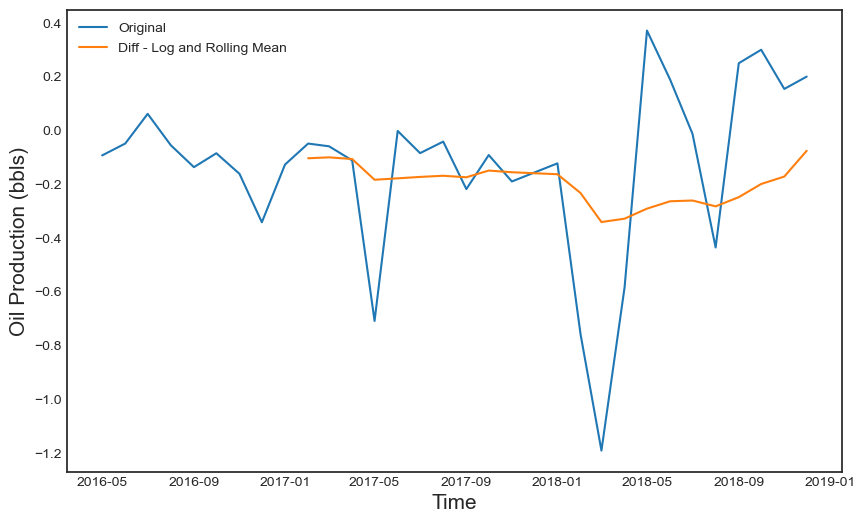

Results of Dickey-Fuller Test:
Test Statistic                -3.72
p-value                        0.00
#Lags Used                     1.00
Number of Observations Used   29.00
Critical Value (1%)           -3.68
Critical Value (5%)           -2.97
Critical Value (10%)          -2.62
dtype: float64


In [10]:
# plot of difference between log(data) and moving average
diff_log_rolmean = ts_log - rolling_mean_log
diff_log_rolmean.dropna(inplace=True)
stationary_test(diff_log_rolmean, "Diff - Log and Rolling Mean")

In [11]:
#Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(diff_log_rolmean)
print("pvalue = ", pvalue, " if above 0.05, data is not stationary")

pvalue =  0.0038897051358521674  if above 0.05, data is not stationary


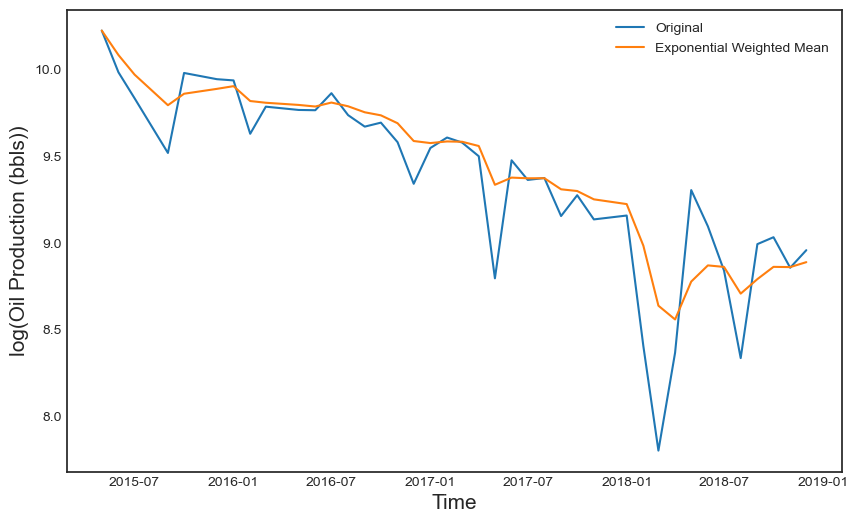

In [12]:
# exponential weighted calculations
weighted_avg_exp = ts_log.ewm(halflife=2).mean()
plt.figure(figsize=(10, 6))

orig = plt.plot(ts_log, label="Original")
mean = plt.plot(weighted_avg_exp, label="Exponential Weighted Mean")
#plt.title("Exponential Weighted Mean - With Log Transformation")
plt.xlabel('Time', fontsize = 15)
plt.ylabel('log(Oil Production (bbls))', fontsize = 15)
plt.legend(loc="best")
plt.show()


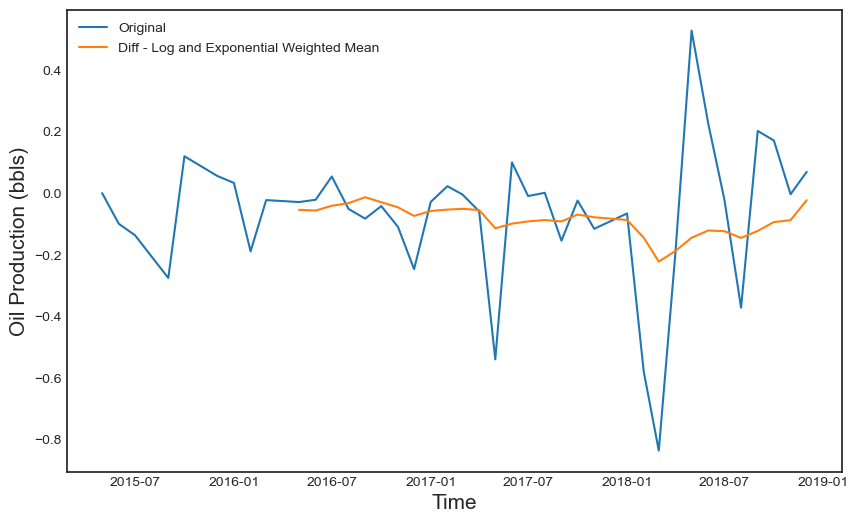

Results of Dickey-Fuller Test:
Test Statistic                -5.30
p-value                        0.00
#Lags Used                     1.00
Number of Observations Used   38.00
Critical Value (1%)           -3.62
Critical Value (5%)           -2.94
Critical Value (10%)          -2.61
dtype: float64


In [13]:
diff_log_ewm = ts_log - weighted_avg_exp
stationary_test(diff_log_ewm, "Diff - Log and Exponential Weighted Mean")

<Figure size 1000x600 with 0 Axes>

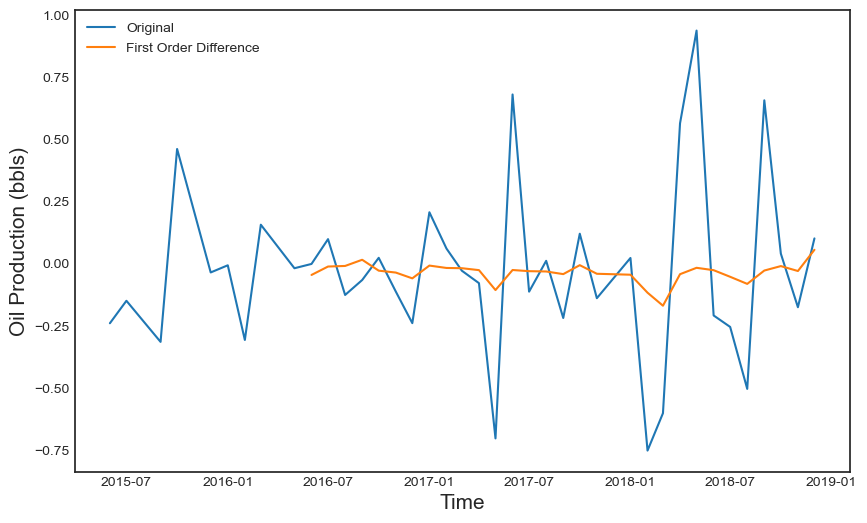

Results of Dickey-Fuller Test:
Test Statistic                -7.16
p-value                        0.00
#Lags Used                     2.00
Number of Observations Used   36.00
Critical Value (1%)           -3.63
Critical Value (5%)           -2.95
Critical Value (10%)          -2.61
dtype: float64


In [14]:
first_order_diff = ts_log - ts_log.shift()
first_order_diff.dropna(inplace=True)
plt.figure(figsize=(10, 6))
stationary_test(first_order_diff, "First Order Difference")

In [15]:
#Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(first_order_diff)
print("pvalue = ", pvalue, " if above 0.05, data is not stationary")

pvalue =  2.9557904118484166e-10  if above 0.05, data is not stationary


AttributeError: 'Series' object has no attribute 'info'

In [22]:
X_train_temp=first_order_diff.values
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(X_train_temp); axes[0, 0].set_title('Original Series')
plot_acf(X_train_temp, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(X_train_temp.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(X_train_temp.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(X_train_temp.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(X_train_temp.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'diff'

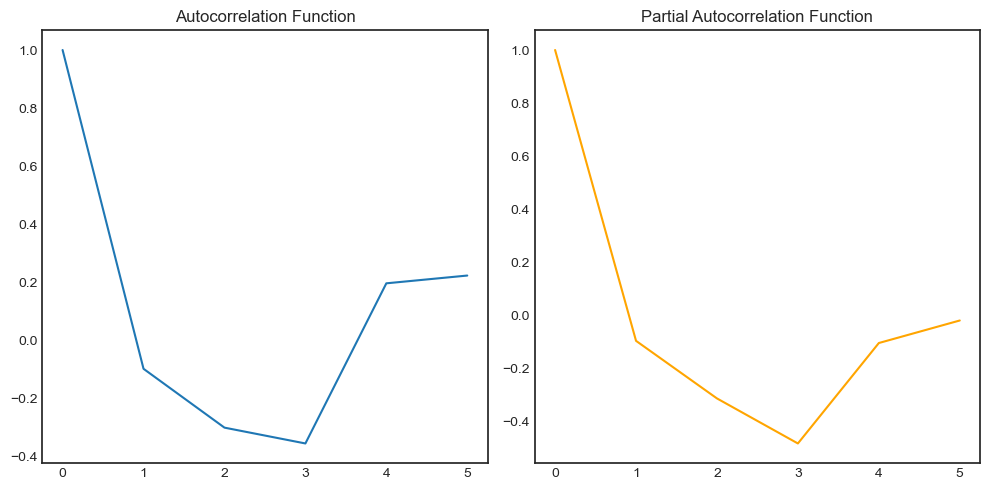

In [14]:
ts_log_diff_active = first_order_diff


lag_acf = acf(ts_log_diff_active, nlags=5)
lag_pacf = pacf(ts_log_diff_active, nlags=5, method="ols")
plt.figure(figsize=(10, 5))

# Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.title("Autocorrelation Function")

# Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf,color='orange')
plt.title("Partial Autocorrelation Function")
plt.tight_layout()
plt.show()


D:\anacondahiss\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anacondahiss\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


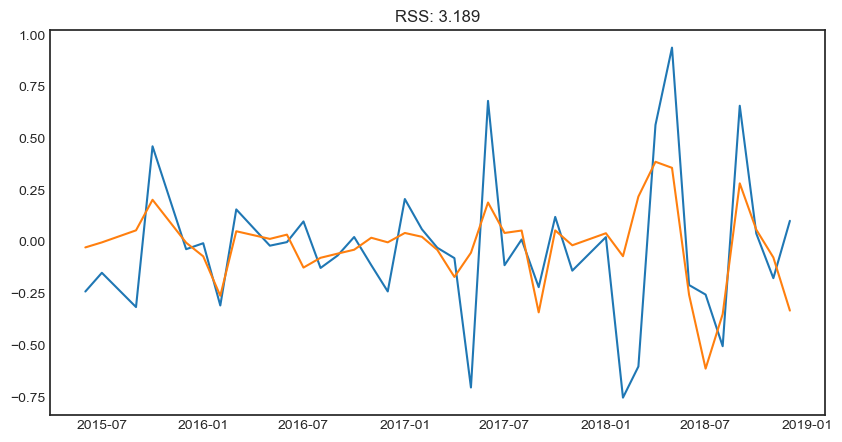

In [15]:
# Auto-Regressive Model (p=3, d=1, q=0)
model_AR = ARIMA(ts_log, order=(3, 1, 0))
results_ARIMA_AR = model_AR.fit(disp=-1)
plt.figure(figsize=(10, 5))
plt.plot(ts_log_diff_active)
plt.plot(results_ARIMA_AR.fittedvalues)
plt.title("RSS: %.3f" % sum((results_ARIMA_AR.fittedvalues - first_order_diff) ** 2))
plt.show()

D:\anacondahiss\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anacondahiss\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


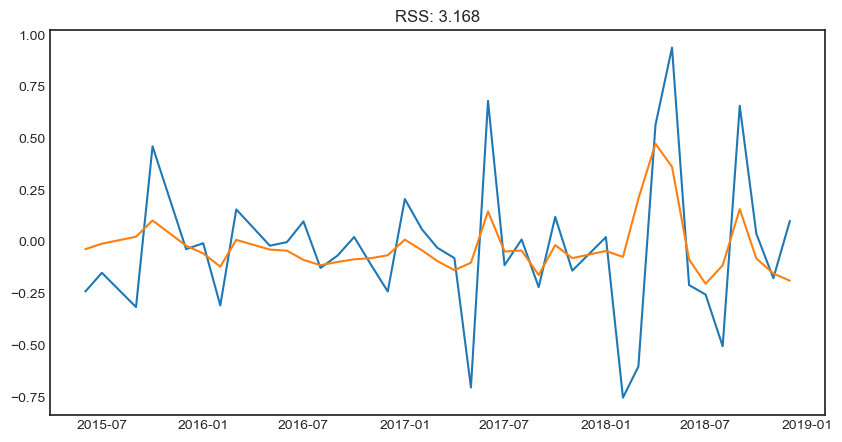

In [16]:
# Moving Average Model (p=0, d=1, q=3)
model_MA = ARIMA(ts_log, order=(0, 1, 3))
results_ARIMA_MA = model_MA.fit(disp=-1)
plt.figure(figsize=(10, 5))
plt.plot(ts_log_diff_active)
plt.plot(results_ARIMA_MA.fittedvalues)
plt.title("RSS: %.3f" % sum((results_ARIMA_MA.fittedvalues - first_order_diff) ** 2))
plt.show()

D:\anacondahiss\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anacondahiss\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                             ARIMA Model Results                              
Dep. Variable:                  D.Oil   No. Observations:                   39
Model:                 ARIMA(3, 1, 3)   Log Likelihood                  -3.889
Method:                       css-mle   S.D. of innovations              0.243
Date:                Thu, 26 Aug 2021   AIC                             23.778
Time:                        07:30:51   BIC                             37.086
Sample:                             1   HQIC                            28.553
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0351      0.005     -6.859      0.000      -0.045      -0.025
ar.L1.D.Oil     0.3544      0.197      1.799      0.072      -0.032       0.741
ar.L2.D.Oil    -0.8949      0.115     -7.799    

D:\anacondahiss\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


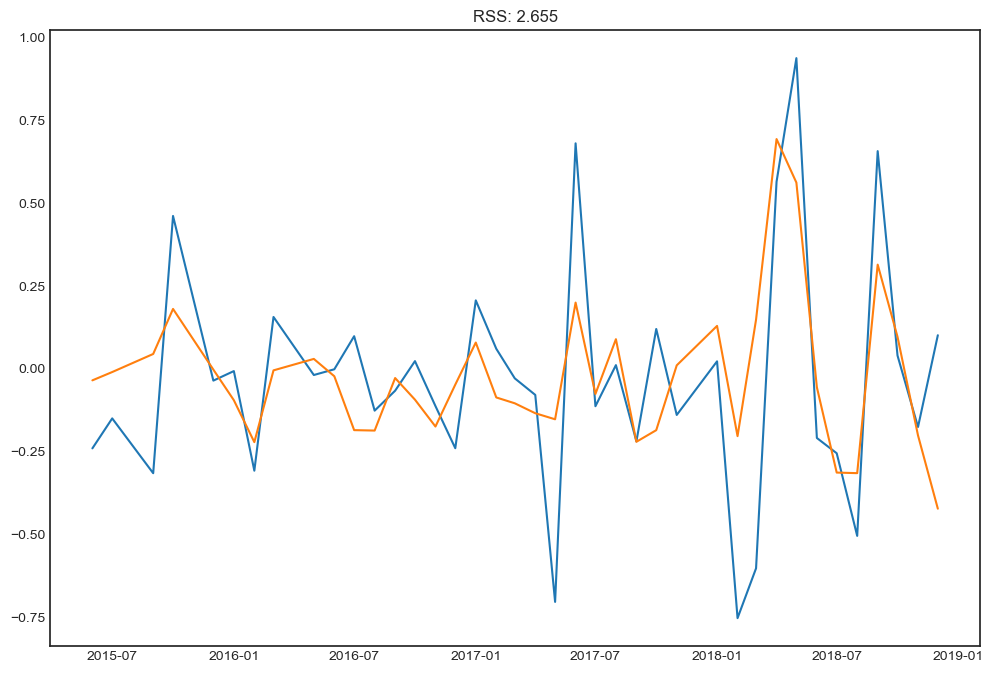

In [17]:
# Combined ARIMA model (p=3, d=1, q=3)
model = ARIMA(ts_log, order=(3, 1, 3))
results_ARIMA = model.fit(disp=-1)
print(results_ARIMA.summary())
plt.plot(ts_log_diff_active)
plt.plot(results_ARIMA.fittedvalues)
plt.title("RSS: %.3f" % sum((results_ARIMA.fittedvalues - first_order_diff) ** 2))
plt.show()

<Figure size 1000x500 with 0 Axes>

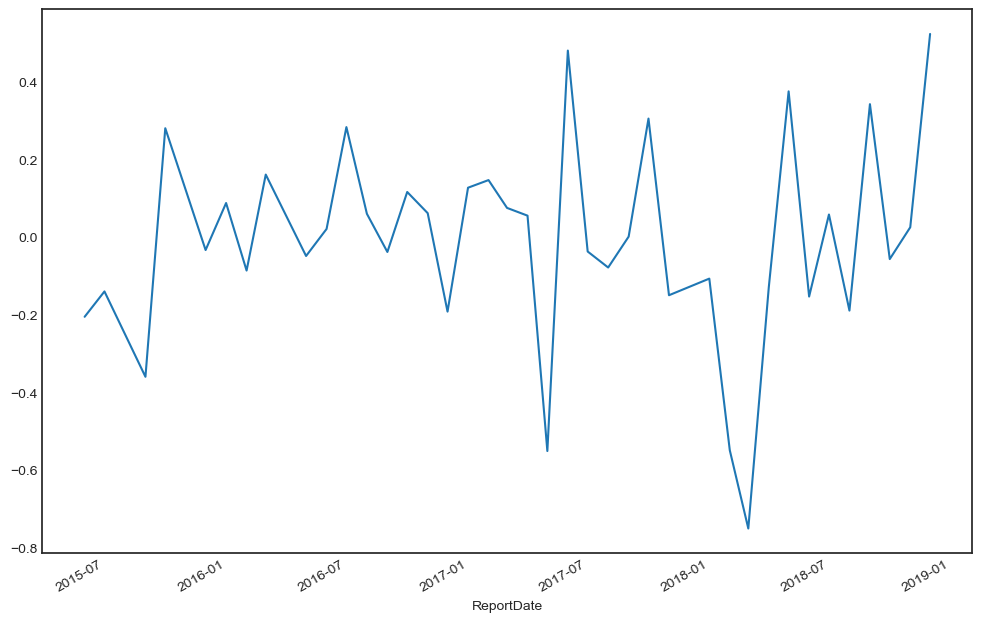

In [18]:
# residual and kde plot
plt.figure(figsize=(10, 5))# plot residual errors
residuals = DataFrame(results_ARIMA.resid)
residuals.plot(legend=None)
#plt.title('Residuals - ARIMA History Match', fontweight='bold', fontsize = 20)
plt.show()

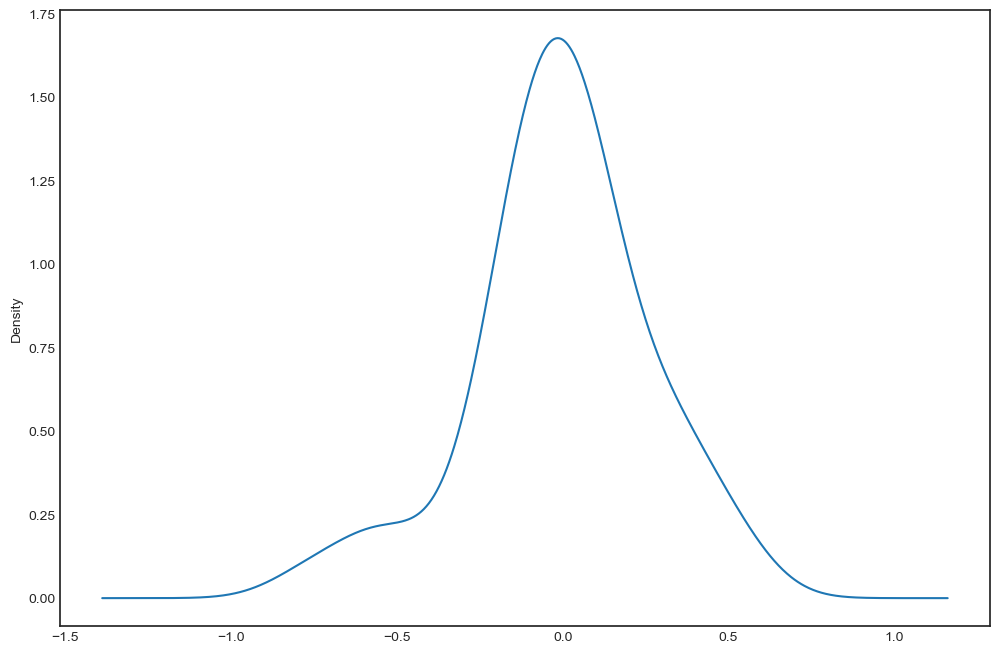

          0
count 39.00
mean  -0.01
std    0.26
min   -0.75
25%   -0.13
50%    0.00
75%    0.12
max    0.52


In [19]:
residuals.plot(kind='kde', legend=None)
#plt.title('Kernel Density Estimation - Plot', fontweight='bold', fontsize = 20)
plt.show()
print(residuals.describe())

D:\anacondahiss\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
D:\anacondahiss\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
D:\anacondahiss\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


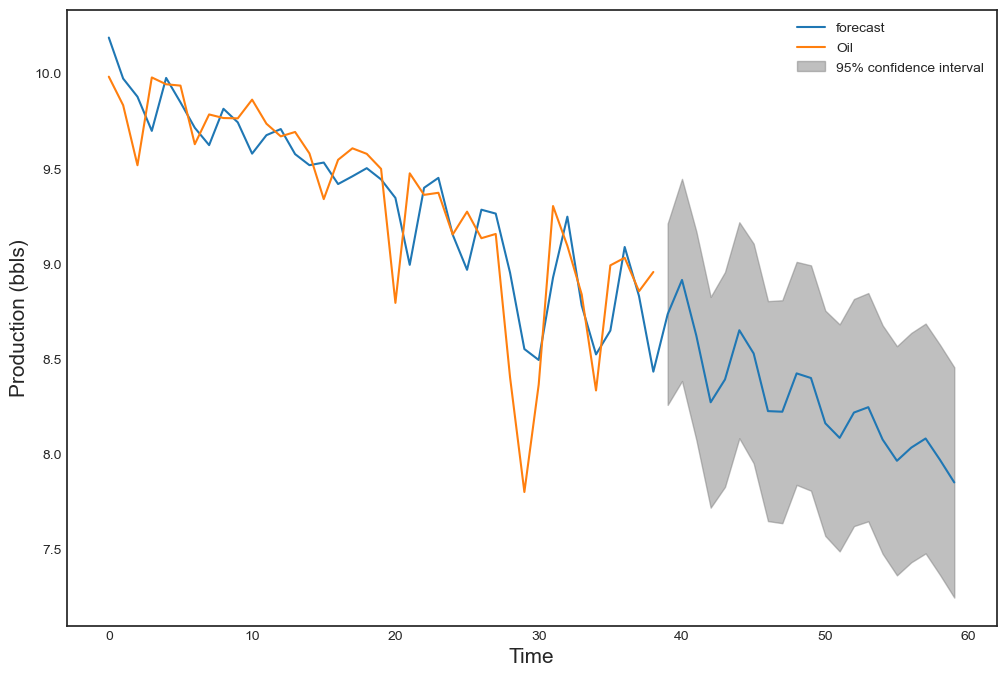

In [20]:
# forecast - ARIMA model
results_ARIMA.plot_predict(1, 60)
#plt.title('ARIMA Model Forecast', fontweight='bold', fontsize = 20)
plt.xlabel('Time' ,fontsize = 15)
plt.ylabel('Production (bbls)' ,fontsize = 15)
plt.show()

In [21]:
# Predictions converted to right units - ARIMA
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_log, index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
print(predictions_ARIMA)

ReportDate
2015-05-01   27545.00
2015-06-01   20910.81
2015-07-01   17820.57
2015-09-01   13591.66
2015-10-01   25830.64
2015-12-01   24856.09
2016-01-01   22445.08
2016-02-01   13217.03
2016-03-01   15379.15
2016-05-01   15545.65
2016-06-01   15173.18
2016-07-01   13907.29
2016-08-01   10166.64
2016-09-01    9250.45
2016-10-01    8622.37
2016-11-01    6469.40
2016-12-01    4850.49
2017-01-01    6454.30
2017-02-01    6286.85
2017-03-01    5501.89
2017-04-01    4444.65
2017-05-01    1886.70
2017-06-01    4551.97
2017-07-01    3766.89
2017-08-01    4163.96
2017-09-01    2681.96
2017-10-01    2512.14
2017-11-01    2207.47
2018-01-01    2569.33
2018-02-01     986.86
2018-03-01     626.57
2018-04-01    2205.30
2018-05-01    9888.32
2018-06-01    7585.99
2018-07-01    4294.94
2018-08-01    1891.41
2018-09-01    4998.56
2018-10-01    5728.90
2018-11-01    3928.43
2018-12-01    2848.50
dtype: float64


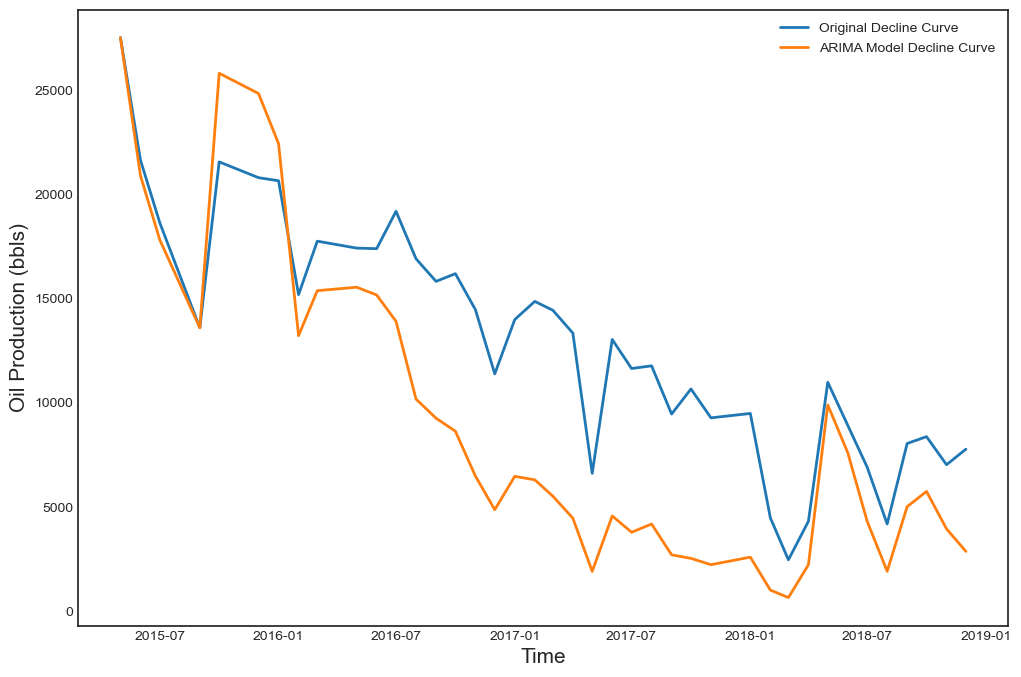

In [22]:
plt.figure(figsize=(12, 8))
plt.plot(timeseries_train, linewidth = 2)
plt.plot(predictions_ARIMA, linewidth = 2)
plt.gca().legend(("Original Decline Curve", "ARIMA Model Decline Curve"))
plt.xlabel('Time', fontsize = 15)
plt.ylabel('Oil Production (bbls)', fontsize = 15)
plt.show()

In [23]:
forecast = results_ARIMA.forecast(steps=12)[0]
# invert the differenced forecast results to covert to right units
X = timeseries_train.values
history = [x for x in X]
months_in_year = 12
Month = 1
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

for yhat in forecast:
    inverted = inverse_difference(history, yhat, months_in_year)
    print(Month, inverted)
    history.append(inverted)
    Month += 1

history
forecast_12_months = history[-12:] # last 12 forecasted values
predictions_ARIMA = predictions_ARIMA.to_numpy()
forecast_12_months = np.array(forecast_12_months)

1 9485.734936309742
2 4470.9148732152835
3 2450.62202529684
4 4303.272083860597
5 10983.391950143774
6 8912.650609569904
7 6906.528518534715
8 4172.2255879460945
9 8043.222427380178
10 8370.423876526203
11 7021.399440009575
12 7768.161810011366


In [24]:
arima_model_results = np.concatenate((predictions_ARIMA, forecast_12_months))
arima_model_results

array([27545.        , 20910.80772087, 17820.568057  , 13591.6605389 ,
       25830.64220268, 24856.09486162, 22445.07907018, 13217.03262317,
       15379.15459109, 15545.65429048, 15173.17698129, 13907.28526972,
       10166.64317143,  9250.44879805,  8622.36541269,  6469.39879919,
        4850.49138304,  6454.30104136,  6286.84537276,  5501.88564787,
        4444.65014758,  1886.6983708 ,  4551.97134828,  3766.89258946,
        4163.96138024,  2681.96095528,  2512.14447676,  2207.47046369,
        2569.32855227,   986.8616072 ,   626.57221121,  2205.30234223,
        9888.31589208,  7585.98727805,  4294.9433537 ,  1891.41343117,
        4998.56286749,  5728.90104644,  3928.42658165,  2848.49782112,
        9485.73493631,  4470.91487322,  2450.6220253 ,  4303.27208386,
       10983.39195014,  8912.65060957,  6906.52851853,  4172.22558795,
        8043.22242738,  8370.42387653,  7021.39944001,  7768.16181001])

In [36]:
timeseries_train.values # oil rate - train
timeseries_test # oil rate - test
forecast_12_months # oil rate - forecast

ts_np = timeseries_train.to_numpy()
ts_forecast = np.array(forecast_12_months)
ts_test_np = timeseries_test.to_numpy()

actual = np.concatenate([ts_np, ts_test_np])
#actual = np.delete(actual, -1)
actual

forecast = np.concatenate([predictions_ARIMA, ts_forecast])
#forecast = np.delete(forecast, -1)
forecast

time = pd.date_range(start='6/1/2015', periods= 54, freq='MS')

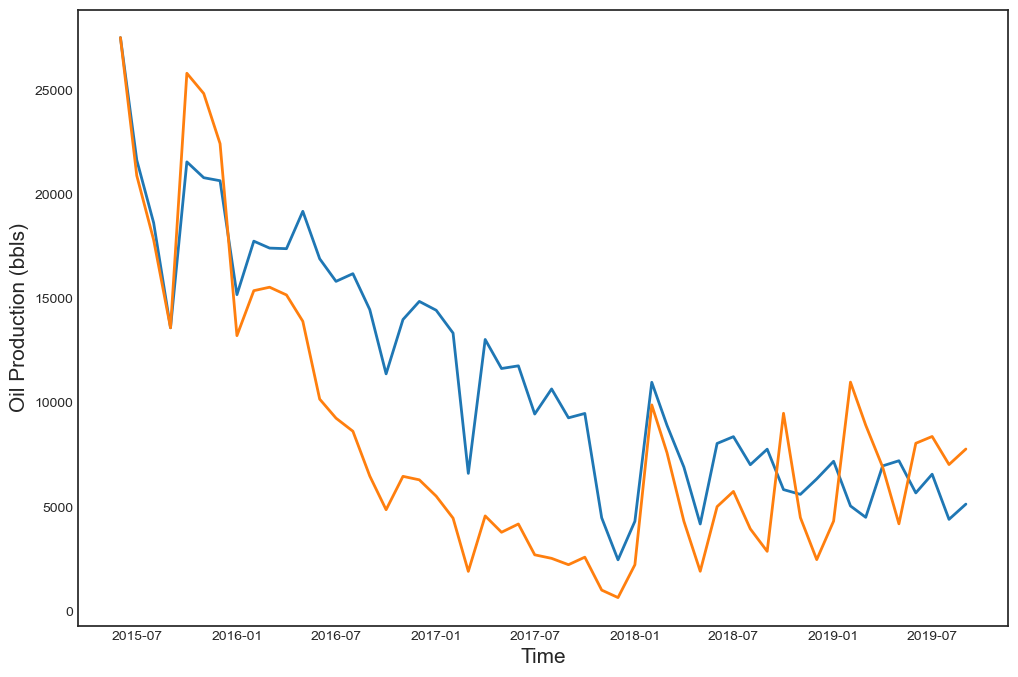

In [38]:
time = pd.date_range(start='6/1/2015', periods= 52, freq='MS')
plt.plot(time,actual, linewidth = 2)
plt.plot(time,forecast, linewidth = 2)
plt.xlabel('Time', fontsize = 15)
plt.ylabel('Oil Production (bbls)', fontsize = 15)
plt.show()

In [27]:
rmse = sqrt(mean_squared_error(actual, forecast))
print("RMSE - ARIMA Method:", rmse)

RMSE - ARIMA Method: 4956.939911045136


In [28]:
rmse_test = sqrt(mean_squared_error(ts_test_np, ts_forecast))
print('Test RMSE:',rmse_test)

Test RMSE: 3229.9950517865946


In [29]:
rmse_train = sqrt(mean_squared_error(ts_np, predictions_ARIMA))
print('Test RMSE:',rmse_train)

Test RMSE: 5326.706914042982


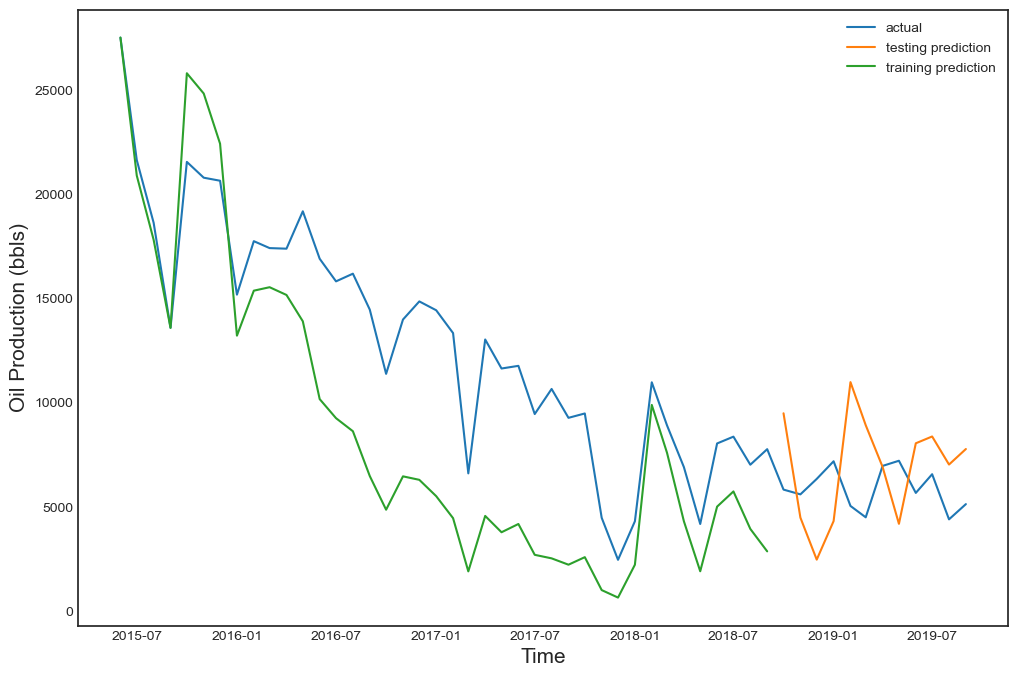

In [42]:
time1 = pd.date_range(start='10/1/2018', periods= 12, freq='MS')
time2 = pd.date_range(start='6/1/2015', periods= 40, freq='MS')
plt.plot(time,np.concatenate([ts_np, ts_test_np]),label='actual' )
#plt.plot(time1,ts_test_np, linewidth = 2)
plt.plot(time1,ts_forecast,label='testing prediction' )
plt.plot(time2,predictions_ARIMA,label='training prediction' )
plt.xlabel('Time', fontsize = 15)
plt.ylabel('Oil Production (bbls)', fontsize = 15)
plt.legend(loc='best')
plt.legend()
plt.show()